# Medical Image Retrieval System

In [9]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader, Dataset
from timm import create_model
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing

In [10]:
df = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")
df["image_id"] = df["image"].apply(lambda x: f"{x}.jpg")
label_columns = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
df["label"] = df[label_columns].idxmax(axis=1).apply(lambda x: label_columns.index(x))

# Select required columns
df = df[["image_id", "label"]]

# Save to CSV
csv_path = "/kaggle/working/HAM10000.csv"
df.to_csv(csv_path, index=False)

In [11]:
df['label'].value_counts()

label
1    6705
0    1113
4    1099
2     514
3     327
6     142
5     115
Name: count, dtype: int64

In [12]:
df.head(2)

,image_id,label
0,ISIC_0024306.jpg,1
1,ISIC_0024307.jpg,1


In [13]:
base_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
csv = "/kaggle/working/HAM10000.csv"  

In [14]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
NUM_CLASSES = 7  
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 5e-4  
NUM_EPOCHS = 6
LAMBDA_KOLEO = 0.9
BETA = 0.5

In [15]:
class MedicalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [10]:
from torch.utils.data import random_split, Subset
# Load Data
dataset = MedicalImageDataset(csv, base_dir, transform=transform)

# Calculate split sizes
total_size = len(dataset)

train_size = int(0.8 * total_size)  
test_size = total_size - train_size  
torch.manual_seed(42)
# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 8012
Test dataset size: 2003


In [11]:
# Model Definition
class MIRViT(nn.Module):
    def __init__(self):
        super(MIRViT, self).__init__()
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
        self.classifier = nn.Linear(384, NUM_CLASSES)

    def forward(self, x):
        features = self.vit(x)
        return features

    def get_embedding(self, x):
        with torch.no_grad():
            features = self.vit(x)
        return features

In [12]:
import torch.nn.functional as F

def contrastive_loss(embeddings, labels):
    N = embeddings.size(0)
    loss = 0.0
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)  #noralize embeddings
    for i in range(N):
        z_i = embeddings[i]
        y_i = labels[i]
        
        positive_sum = 0.0
        negative_sum = 0.0
        positive_count = 0
        negative_count = 0
        
        for j in range(N):
            if i != j:
                z_j = embeddings[j]
                y_j = labels[j]
                sim = torch.clamp(torch.dot(z_i, z_j), min=-1.0, max=1.0)

                if y_i == y_j:
                    positive_sum += (1 - sim)
                    positive_count += 1
                else:
                    negative_sum += max(0, sim - BETA)
                    negative_count += 1
        
        positive_term = positive_sum / (positive_count + 1e-8)
        negative_term = negative_sum / (negative_count + 1e-8)
        loss += positive_term + negative_term
    
    return loss / N

def koleo_loss(embeddings):
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    mask = torch.eye(similarity_matrix.size(0), device=embeddings.device).bool()
    similarity_matrix[mask] = -1e6  # Replace diagonal with large negative value

    min_similarity, _ = torch.min(similarity_matrix, dim=1)
    rho_i = torch.clamp(min_similarity + 1e-8, min=1e-8)  # Ensure positivity
    return -torch.mean(torch.log(rho_i))

In [13]:
def train_model(model, train_loader, optimizer, lambda_koleo=0.3):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        embeddings = model(images)
        contrastive_loss_value = contrastive_loss(embeddings, labels)
        # print("contrastive_loss_value = ", contrastive_loss_value)
        
        koleo_loss_value = koleo_loss(embeddings)
        # print("koleo_loss_value = ", koleo_loss_value)
        
        total_loss_value = contrastive_loss_value + lambda_koleo * koleo_loss_value
        if torch.isnan(total_loss_value):
            # print("NaN detected, skipping this batch!")
            continue
        
        total_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += total_loss_value.item()
        # print("total_loss = ", total_loss)
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch Loss: {avg_loss:.4f}")

In [14]:
def evaluate_model(model, test_loader, normalize_embeddings=True):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to the same device as the model
            labels = labels.to(device)  # Move labels if needed
            embeddings = model.get_embedding(images)
            
            if normalize_embeddings:
                embeddings = F.normalize(embeddings, p=2, dim=1)
            
            all_embeddings.append(embeddings)
            all_labels.append(labels)
    
    # Concatenate all embeddings and labels
    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    
    return all_embeddings, all_labels 

In [15]:
# Initialize Model and Optimizer
model = MIRViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [16]:
# Train the Model 
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}') 
    train_model(model, train_loader, optimizer) 

Epoch 1/6


100%|██████████| 126/126 [08:58<00:00,  4.27s/it]


Epoch Loss: 5.8529
Epoch 2/6


100%|██████████| 126/126 [08:04<00:00,  3.85s/it]


Epoch Loss: 5.7874
Epoch 3/6


100%|██████████| 126/126 [08:04<00:00,  3.85s/it]


Epoch Loss: 5.7688
Epoch 4/6


100%|██████████| 126/126 [08:01<00:00,  3.82s/it]


Epoch Loss: 5.7414
Epoch 5/6


100%|██████████| 126/126 [08:02<00:00,  3.83s/it]


Epoch Loss: 5.7265
Epoch 6/6


100%|██████████| 126/126 [08:02<00:00,  3.83s/it]

Epoch Loss: 5.7205


In [64]:
NUM_EPOCHS = 8
# Train the Model 
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}') 
    train_model(model, train_loader, optimizer) 

Epoch 1/8


100%|██████████| 126/126 [07:55<00:00,  3.78s/it]


Epoch Loss: 5.7006
Epoch 2/8


100%|██████████| 126/126 [07:56<00:00,  3.78s/it]


Epoch Loss: 5.6925
Epoch 3/8


100%|██████████| 126/126 [07:55<00:00,  3.77s/it]


Epoch Loss: 5.6916
Epoch 4/8


100%|██████████| 126/126 [07:56<00:00,  3.78s/it]


Epoch Loss: 5.6826
Epoch 5/8


100%|██████████| 126/126 [07:55<00:00,  3.77s/it]


Epoch Loss: 5.6687
Epoch 6/8


100%|██████████| 126/126 [07:53<00:00,  3.76s/it]


Epoch Loss: 5.6683
Epoch 7/8


100%|██████████| 126/126 [07:52<00:00,  3.75s/it]


Epoch Loss: 5.6489
Epoch 8/8


100%|██████████| 126/126 [07:53<00:00,  3.76s/it]

Epoch Loss: 5.6461


In [65]:
# Evaluate the Model
train_embeddings, train_labels = evaluate_model(model, train_loader)   
test_embeddings, test_labels = evaluate_model(model, test_loader) 

In [70]:
# Move the tensors to CPU and then convert to NumPy arrays
np.savez("embeddings_and_labels_HAM10000_99.88.npz",
         train_embeddings=train_embeddings.cpu().numpy(),
         train_labels=train_labels.cpu().numpy(),
         test_embeddings=test_embeddings.cpu().numpy(), 
         test_labels=test_labels.cpu().numpy())
print("Embeddings and labels saved to embeddings_and_labels.npz")

Embeddings and labels saved to embeddings_and_labels.npz


In [59]:
test_labels_cpu = test_labels.cpu()
test_labels_np = test_labels_cpu.numpy()
test_labels_series = pd.Series(test_labels_np)
test_labels_series.value_counts()

1    1346
0     226
4     222
2      90
3      60
6      32
5      27
Name: count, dtype: int64

In [45]:
# Cosine Similarity for Retrieval
# def retrieve_images(query_embedding, database_embeddings, top_k=10):
#     """Retrieve top K images based on cosine similarity."""
#     similarities = cosine_similarity(query_embedding.cpu().numpy(), database_embeddings.cpu().numpy())
#     indices = np.argsort(-similarities, axis=1)[:, :top_k]
#     return indices

def retrieve_images(query_embedding, database_embeddings, top_k=10):
    """Retrieve top K images based on cosine similarity."""
    similarities = cosine_similarity(query_embedding, database_embeddings)
    indices = np.argsort(-similarities, axis=1)[:, :top_k]
    return indices

def calculate_average_precision(true_labels, retrieved_labels):
    """Calculates Average Precision (AP) for a single query."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    for idx, label in enumerate(retrieved_labels):
        if label == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map(query_labels, retrieved_labels):
    """Calculates Mean Average Precision (mAP) for all queries."""
    ap_scores = []
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        ap = calculate_average_precision(true_label, retrieved)
        ap_scores.append(ap)
    return np.mean(ap_scores)

def calculate_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates precision at K for each query, then averages across all queries."""
    precisions = []
    for true_label, retrieved in zip(true_labels, retrieved_labels):
        top_k_labels = retrieved[:k]
        precision_k = sum([1 for label in top_k_labels if label == true_label]) / k
        precisions.append(precision_k)
    return np.mean(precisions)

def calculate_recall_at_k(true_labels, retrieved_labels, k):
    recalls = []
    for i, (true_label, retrieved) in enumerate(zip(true_labels, retrieved_labels)):
        # Check if true label is in the top-K retrieved labels
        relevant_retrieved = 1 if true_label in retrieved[:k] else 0
        
        # Recall is 1 if relevant item is retrieved, otherwise 0
        recall_k = relevant_retrieved
        recalls.append(recall_k)
        
    # Average recall across all queries
    mean_recall = np.mean(recalls)
    
    return mean_recall

In [43]:
# query_labels = []  # List of true labels for each query
# retrieved_labels = []  # List of retrieved labels for each query

# for i in range(len(test_embeddings)):
#     query_embedding = test_embeddings[i].unsqueeze(0)
#     query_label = test_labels[i].item()  # Convert to scalar if tensor

#     # Get indices of top-10 most similar images
#     top_indices = retrieve_images(query_embedding, train_embeddings, top_k=10)
#     top_labels = train_labels[top_indices].flatten().tolist()  # Convert to list
    
#     # Store the true label and retrieved labels for mAP and P@K calculations
#     query_labels.append(query_label)
#     retrieved_labels.append(top_labels)

In [47]:
query_labels = []  
retrieved_labels = []  

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]
    # query_embedding = test_embeddings1[i].unsqueeze(0)
    # query_label = test_labels1[i].item()  # Convert to scalar if tensor

    # Get indices of top-10 most similar images
    top_indices = retrieve_images(query_embedding, train_embeddings1, top_k=10)
    top_labels = train_labels1[top_indices].flatten().tolist()  # Convert to list
    
    # Store the true label and retrieved labels for mAP and P@K calculations
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# for i in range(len(test_embeddings1)):
#     query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
#     query_label = test_labels[i]  # True label of the query
#     query_cluster = fcm_model.predict(query_embedding1.cpu().numpy())[0]
#     top_labels = retrieve_images_with_clusters(
#         query_embedding, train_embeddings, train_labels, train_cluster_labels, query_cluster, top_k=20
#     ) 
#     # Store the labels 
#     query_labels.append(query_label) 
#     retrieved_labels.append(top_labels)

In [49]:
def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

mP@1: 0.7583624563155267
mP@5: 0.8058897764464414
mP@10: 0.7987576105450039


In [50]:
# Calculate mAP
map_score = calculate_map(query_labels, retrieved_labels)

# Calculate P@1, P@5 and P@10
p_at_1 = calculate_precision_at_k(query_labels, retrieved_labels, k=1)
p_at_5 = calculate_precision_at_k(query_labels, retrieved_labels, k=5)
p_at_10 = calculate_precision_at_k(query_labels, retrieved_labels, k=10)

# Calculate Recall@1, @5, @10
r_at_1 = calculate_recall_at_k(query_labels, retrieved_labels, k=1)
r_at_5 = calculate_recall_at_k(query_labels, retrieved_labels, k=5)
r_at_10 = calculate_recall_at_k(query_labels, retrieved_labels, k=10)

print(f"mAP: {map_score:.4f}")
print(f"P@1: {p_at_1:.4f}")
print(f"P@5: {p_at_5:.4f}")
print(f"P@10: {p_at_10:.4f}")
print(f"R@1: {r_at_1:.4f}")
print(f"R@5: {r_at_5:.4f}")
print(f"R@10: {r_at_10:.4f}")

mAP: 0.7988
P@1: 0.7584
P@5: 0.7592
P@10: 0.7579
R@1: 0.7584
R@5: 0.9066
R@10: 0.9396


In [ ]:
# mAP: 0.7782 ==>8

In [71]:
def display_retrieved_images(query_images, retrieved_images, query_labels, retrieved_labels, max_retrieved=10):
    # Label mapping dictionary
    label_mapping = { 
     0 : "MEL",
     1 : "NV",
     2 : "BCC",
     3 : "AKIEC",
     4 : "BKL",
     5 : "DF",
     6 : "VASC"
}
    
    # Number of queries to process
    num_queries = len(query_images)
    
    # Set up the plot with 1 row and (num_retrieved + 1) columns for each query
    fig, axes = plt.subplots(num_queries, max_retrieved + 1, figsize=(15, 5 * num_queries))
    
    if num_queries == 1:  # when we only have 1 query
        axes = [axes]
    
    for query_idx in range(num_queries):
        # Ensure the number of retrieved images does not exceed max_retrieved
        num_retrieved = min(len(retrieved_images[query_idx]), max_retrieved)
        
        # Display the query image with its label
        axes[query_idx][0].imshow(query_images[query_idx])
        axes[query_idx][0].set_title(f"Query Label: {label_mapping.get(query_labels[query_idx], 'Unknown')}")
        axes[query_idx][0].axis('off')
        
        # Display the retrieved images with their labels
        for i, (img, label) in enumerate(zip(retrieved_images[query_idx][:num_retrieved], retrieved_labels[query_idx][:num_retrieved])):
            axes[query_idx][i + 1].imshow(img)
            axes[query_idx][i + 1].set_title(f"Label: {label_mapping.get(label, 'Unknown')}")
            axes[query_idx][i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

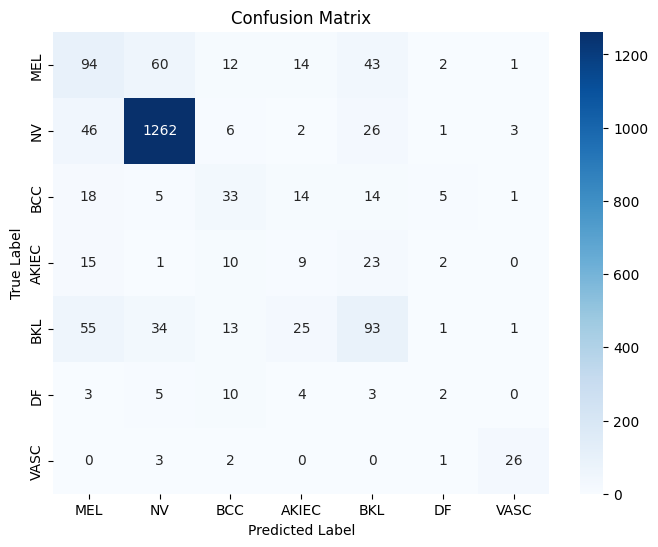

Classification Report:

              precision    recall  f1-score   support

         MEL       0.41      0.42      0.41       226
          NV       0.92      0.94      0.93      1346
         BCC       0.38      0.37      0.37        90
       AKIEC       0.13      0.15      0.14        60
         BKL       0.46      0.42      0.44       222
          DF       0.14      0.07      0.10        27
        VASC       0.81      0.81      0.81        32

    accuracy                           0.76      2003
   macro avg       0.47      0.45      0.46      2003
weighted avg       0.75      0.76      0.75      2003



In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Gather true labels and top-1 predictions
true_labels = []  # True labels for each query
top1_predictions = []  # Top-1 predicted labels for each query

for i in range(len(test_embeddings)):
    query_embedding = test_embeddings[i].unsqueeze(0)
    query_label = test_labels[i].item()  # Convert to scalar if tensor

    # Retrieve top-1 result
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=1)
    top_label = train_labels[top_indices[0][0]].item()  # Get the top-1 label

    true_labels.append(query_label)
    top1_predictions.append(top_label)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, top1_predictions)
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate Classification Report
report = classification_report(true_labels, top1_predictions, target_names=class_names)
print("Classification Report:\n")
print(report)

In [73]:
# Select query indices 
query_indices = [1, 555, 1190, 2000, 999, 1865, 343] 

query_images = [test_dataset[idx][0] for idx in query_indices] 
query_labels = [test_labels[idx].item() for idx in query_indices]  

# Retrieve top-10 most similar images 
top_k = 10
retrieved_images = []
retrieved_labels = []
for query_index in query_indices:
    query_embedding = test_embeddings[query_index].unsqueeze(0)
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=top_k)
    
    # Collect retrieved images and labels for the current query
    retrieved_images.append([train_dataset[idx][0] for idx in top_indices[0]])
    retrieved_labels.append([train_labels[idx] for idx in top_indices[0]])

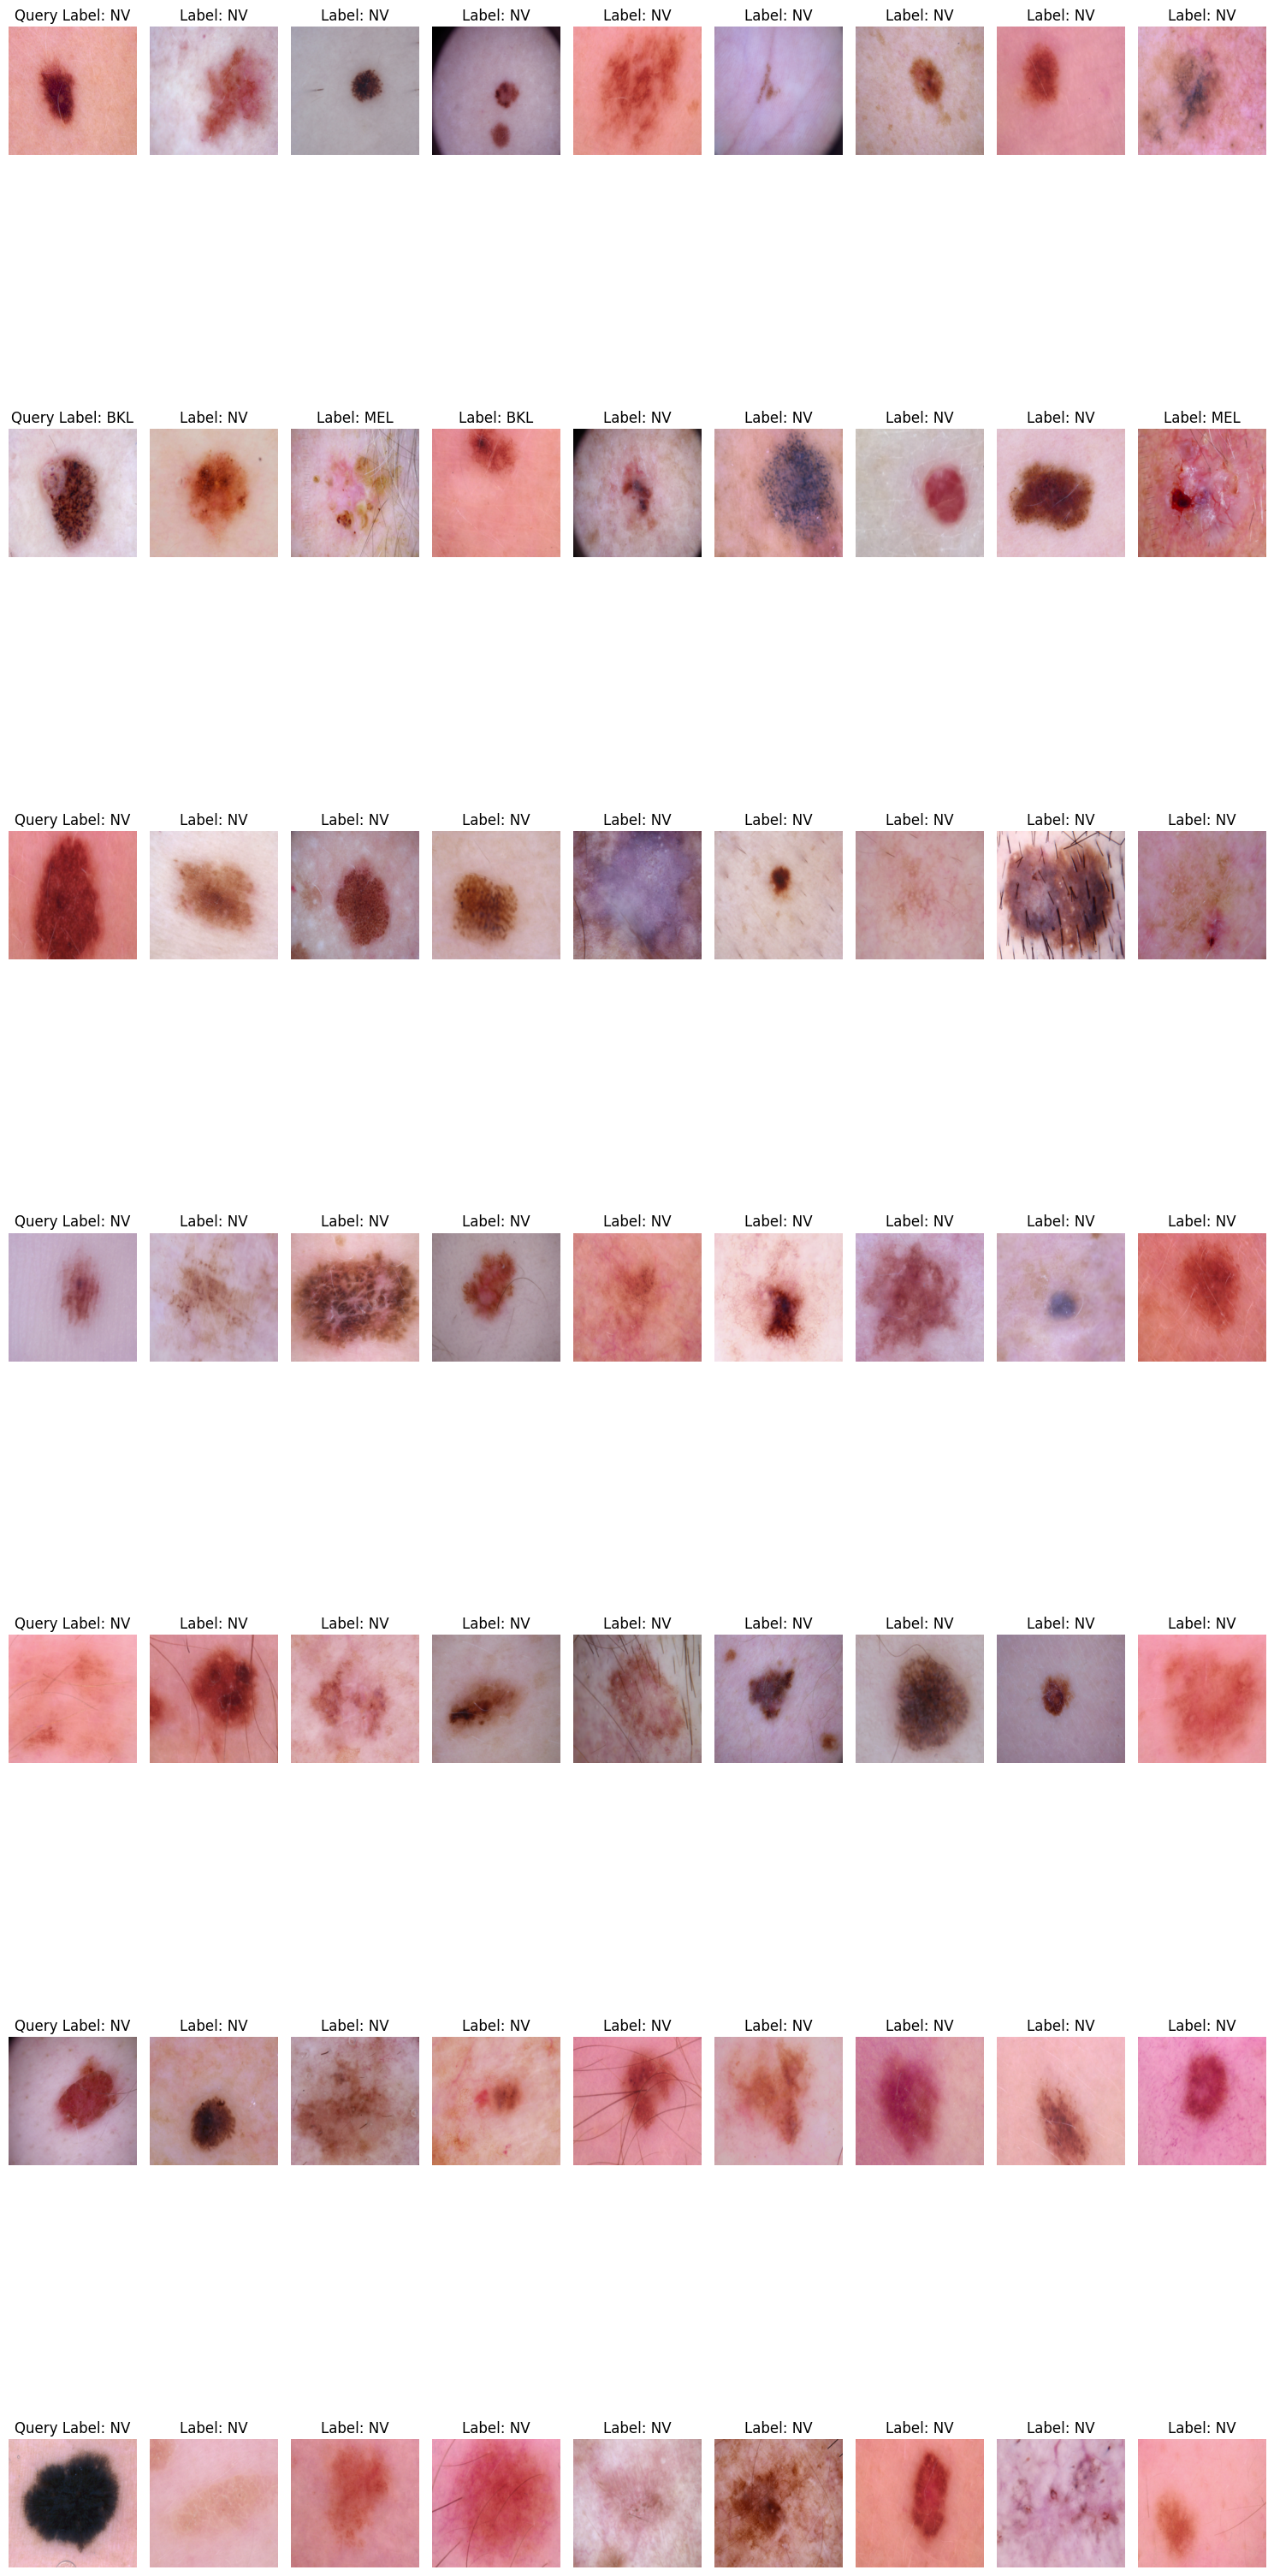

In [74]:
# Display the query images and retrieved images
display_retrieved_images(
    [img.permute(1, 2, 0).cpu().numpy() for img in query_images],  # Convert query images to HWC format
    [[img.permute(1, 2, 0).cpu().numpy() for img in imgs] for imgs in retrieved_images],
    query_labels,
    [[label.item() for label in labels] for labels in retrieved_labels], 
    max_retrieved=8
) 

# FUZZY C MEANS CLUSTERING

In [17]:
!pip install scikit-learn-extra
!pip install fuzzy-c-means
from fcmeans import FCM 
import warnings
from sklearn.metrics import silhouette_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [26]:
# Load the saved .npz file
data = np.load("/kaggle/input/dataaa/embeddings_and_labels_HAM10000_99.88.npz")
# Extract the arrays
train_embeddings1 = data['train_embeddings']
train_labels1 = data['train_labels']
test_embeddings1 = data['test_embeddings']
test_labels1 = data['test_labels']

In [27]:
silhouette_score(train_embeddings1, train_labels1)

0.5183604

In [21]:
def retrieve_images_with_clusters(query_embedding, database_embeddings, database_labels, cluster_labels, query_cluster, top_k=10):
    # Filter database to only include embeddings in the same cluster as the query
    cluster_indices = np.where(cluster_labels == query_cluster)[0]
    cluster_embeddings = database_embeddings[cluster_indices]
    cluster_labels_filtered = database_labels[cluster_indices]

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, cluster_embeddings)
    indices = np.argsort(-similarities, axis=1)[:, :top_k]
    # print("indices", indices)
    # Map indices back to original labels
    retrieved_labels = cluster_labels_filtered[indices].flatten().tolist()
    # print("retrieved_labels", retrieved_labels)
    return retrieved_labels

# fuzzy c means

In [31]:
n_clusters = 615 
m = 1.5  
max_iter = 200  
error = 1e-7  
random_state = 100  
fcm_model = FCM(n_clusters=n_clusters, m=m, max_iter=max_iter, error=error, random_state=random_state) 
fcm_model.fit(train_embeddings1)  
train_cluster_labels = fcm_model.u.argmax(axis=1) 

query_labels = []  
retrieved_labels = []  

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  # True label of the query
    query_cluster = fcm_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)

# Calculate mAP, Precision@K, and Recall@K 
map_score = calculate_map(query_labels, retrieved_labels)
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}") 
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7906
Precision@1: 0.7594
Recall@1: 0.7594
Precision@5: 0.7334
Recall@5: 0.8802
Precision@10: 0.7144
Recall@10: 0.9026


In [32]:
def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

mP@1: 0.7593609585621568
mP@5: 0.8008341654185389
mP@10: 0.7943111077431472


# kmeans

In [181]:
from sklearn.cluster import KMeans
n_clusters = 1200
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7968
Precision@1: 0.7604
Recall@1: 0.7604
Precision@5: 0.7151
Recall@5: 0.8672
Precision@10: 0.6611
Recall@10: 0.8842
mP@1: 0.7603594608087868
mP@5: 0.7998994563709991
mP@10: 0.7975365136346878


In [182]:
from sklearn.cluster import KMeans
n_clusters = 1222
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7891
Precision@1: 0.7534
Recall@1: 0.7534
Precision@5: 0.7082
Recall@5: 0.8612
Precision@10: 0.6550
Recall@10: 0.8777
mP@1: 0.7533699450823764
mP@5: 0.7903602928939923
mP@10: 0.7898243903199119


In [183]:
from sklearn.cluster import KMeans
n_clusters = 1208
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7872
Precision@1: 0.7529
Recall@1: 0.7529
Precision@5: 0.7145
Recall@5: 0.8592
Precision@10: 0.6577
Recall@10: 0.8697
mP@1: 0.7528706939590614
mP@5: 0.7922082154545957
mP@10: 0.7881180954380976


In [131]:
from sklearn.cluster import KMeans
n_clusters = 663
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7900
Precision@1: 0.7589
Recall@1: 0.7589
Precision@5: 0.7329
Recall@5: 0.8757
Precision@10: 0.7131
Recall@10: 0.9056


In [132]:
from sklearn.cluster import KMeans
n_clusters = 664
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7886
Precision@1: 0.7539
Recall@1: 0.7539
Precision@5: 0.7337
Recall@5: 0.8827
Precision@10: 0.7112
Recall@10: 0.9056


In [133]:
from sklearn.cluster import KMeans
n_clusters = 665
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7908
Precision@1: 0.7594
Recall@1: 0.7594
Precision@5: 0.7364
Recall@5: 0.8842
Precision@10: 0.7148
Recall@10: 0.9056


In [28]:
from sklearn.cluster import KMeans
n_clusters = 665
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7908
Precision@1: 0.7594
Recall@1: 0.7594
Precision@5: 0.7364
Recall@5: 0.8842
Precision@10: 0.7148
Recall@10: 0.9056


In [30]:
def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

mP@1: 0.7593609585621568
mP@5: 0.8000943029899595
mP@10: 0.7947835666505282


In [185]:
from sklearn.cluster import KMeans
n_clusters = 1235
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7944
Precision@1: 0.7619
Recall@1: 0.7619
Precision@5: 0.7107
Recall@5: 0.8662
Precision@10: 0.6568
Recall@10: 0.8777


In [186]:
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

mP@1: 0.7618572141787319
mP@5: 0.7966002385310923
mP@10: 0.7947054097613973


In [188]:
from sklearn.cluster import KMeans
n_clusters = 1245
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7913
Precision@1: 0.7529
Recall@1: 0.7529
Precision@5: 0.7074
Recall@5: 0.8652
Precision@10: 0.6536
Recall@10: 0.8777
mP@1: 0.7528706939590614
mP@5: 0.7931117213069285
mP@10: 0.7917059421261153


In [179]:
from sklearn.cluster import KMeans
n_clusters = 1230
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)
train_cluster_labels = kmeans_model.labels_

# Evaluate Retrieval Performance
query_labels = []  
retrieved_labels = []  
for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels)
    
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7933
Precision@1: 0.7609
Recall@1: 0.7609
Precision@5: 0.7099
Recall@5: 0.8642
Precision@10: 0.6602
Recall@10: 0.8772
mP@1: 0.7608587119321019
mP@5: 0.796658484495479
mP@10: 0.7938674781824491


# Kmedoids

In [126]:
from sklearn_extra.cluster import KMedoids
n_clusters = 1221
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7997
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7132
Recall@5: 0.8632
Precision@10: 0.6534
Recall@10: 0.8757


In [127]:
def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

mP@1: 0.7743384922616076
mP@5: 0.8027937260775504
mP@10: 0.8005805821061805


In [128]:
n_clusters = 1222   
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7998
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7132
Recall@5: 0.8632
Precision@10: 0.6531
Recall@10: 0.8757
mP@1: 0.7743384922616076
mP@5: 0.8028908026848616
mP@10: 0.8006862130588446


In [129]:
n_clusters = 1224   
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7999
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7128
Recall@5: 0.8632
Precision@10: 0.6527
Recall@10: 0.8757
mP@1: 0.7743384922616076
mP@5: 0.8028908026848616
mP@10: 0.8007137731296731


In [130]:
n_clusters = 1225   
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7999
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7128
Recall@5: 0.8632
Precision@10: 0.6527
Recall@10: 0.8757
mP@1: 0.7743384922616076
mP@5: 0.8028908026848616
mP@10: 0.8007137731296731


In [131]:
n_clusters = 1229
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7995
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7127
Recall@5: 0.8627
Precision@10: 0.6527
Recall@10: 0.8752
mP@1: 0.7743384922616076
mP@5: 0.8025163643423753
mP@10: 0.8003476556392422


In [138]:
n_clusters = 1249
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7990
Precision@1: 0.7743
Recall@1: 0.7743
Precision@5: 0.7102
Recall@5: 0.8612
Precision@10: 0.6507
Recall@10: 0.8737
mP@1: 0.7743384922616076
mP@5: 0.8019332112941698
mP@10: 0.7997673666968683


In [169]:
n_clusters = 1306
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7972
Precision@1: 0.7723
Recall@1: 0.7723
Precision@5: 0.7062
Recall@5: 0.8597
Precision@10: 0.6435
Recall@10: 0.8707
mP@1: 0.7723414877683474
mP@5: 0.7998855882842403
mP@10: 0.7979098162720646


In [170]:
n_clusters = 1307
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7965
Precision@1: 0.7718
Recall@1: 0.7718
Precision@5: 0.7061
Recall@5: 0.8592
Precision@10: 0.6433
Recall@10: 0.8702
mP@1: 0.7718422366450325
mP@5: 0.7993204637488212
mP@10: 0.7972167421266688


In [171]:
n_clusters = 1308  
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7965
Precision@1: 0.7718
Recall@1: 0.7718
Precision@5: 0.7061
Recall@5: 0.8592
Precision@10: 0.6433
Recall@10: 0.8702
mP@1: 0.7718422366450325
mP@5: 0.7993204637488212
mP@10: 0.7972167421266688


In [172]:
n_clusters = 1309
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_ 
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k)
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7965
Precision@1: 0.7718
Recall@1: 0.7718
Precision@5: 0.7062
Recall@5: 0.8592
Precision@10: 0.6433
Recall@10: 0.8702
mP@1: 0.7718422366450325
mP@5: 0.7993204637488212
mP@10: 0.797247733055242


In [173]:
n_clusters = 1310
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  
kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")
for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

def calculate_average_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates Average Precision (AP) for a single query at rank K."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    # Limit the iteration to the length of the retrieved_labels (if less than k)
    for idx in range(min(k, len(retrieved_labels))):
        if retrieved_labels[idx] == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map_at_k(query_labels, retrieved_labels, k_values=[1, 5, 10]):
    """Calculates Mean Average Precision (mAP) for all queries at specific K values."""
    ap_scores = {k: [] for k in k_values}
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        for k in k_values:
            ap_at_k = calculate_average_precision_at_k(true_label, retrieved, k)
            ap_scores[k].append(ap_at_k) 
    # Calculate mean average precision for each K
    map_at_k = {k: np.mean(ap_scores[k]) for k in k_values}
    return map_at_k
    
mAP_at_k = calculate_map_at_k(query_labels, retrieved_labels)
print(f"mP@1: {mAP_at_k[1]}")
print(f"mP@5: {mAP_at_k[5]}")
print(f"mP@10: {mAP_at_k[10]}")

Mean Average Precision (mAP): 0.7965
Precision@1: 0.7718
Recall@1: 0.7718
Precision@5: 0.7062
Recall@5: 0.8592
Precision@10: 0.6434
Recall@10: 0.8702
mP@1: 0.7718422366450325
mP@5: 0.7993204637488212
mP@10: 0.7972743025484449
